In [14]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
import logging
from pyspark.sql.functions import col, sum as pyspark_sum, countDistinct
from pyspark.sql.functions import to_timestamp
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import numpy as np
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, unix_timestamp, hour, dayofmonth, month, year, to_timestamp

# Create SparkSession
spark = SparkSession.builder \
                    .appName('a4pt4') \
                    .getOrCreate()

In [15]:
# Importing datasets as pyspark dataframe
df = spark.read.format("csv") \
             .option("header", "true") \
             .option("inferSchema", "true") \
             .load("joined04.csv")

### balance classes

In [16]:
# Count the number of instances for each class
class_counts = df.groupBy("music_effects").count().collect()
class_counts_dict = {row['music_effects']: row['count'] for row in class_counts}

# Calculate the maximum class count
max_count = max(class_counts_dict.values())

# Define a function to balance the classes
def balance_classes(df, class_counts, max_count):
    sampled_dfs = []
    for cls, count in class_counts.items():
        if count < max_count:
            fraction = max_count / count
            sampled_df = df.filter(col("music_effects") == cls).sample(withReplacement=True, fraction=fraction, seed=42)
        else:
            sampled_df = df.filter(col("music_effects") == cls)
        sampled_dfs.append(sampled_df)
    return sampled_dfs

# Apply the function to balance the classes
sampled_dfs = balance_classes(df, class_counts_dict, max_count)
balanced_df = sampled_dfs[0]
for sampled_df in sampled_dfs[1:]:
    balanced_df = balanced_df.union(sampled_df)

# Verify the class distribution
balanced_df.groupBy("music_effects").count().show()

+-------------+-----+
|music_effects|count|
+-------------+-----+
|            1|  524|
|            3|  546|
|            2|  542|
+-------------+-----+



In [17]:
# Split the balanced data into training and test sets of 80/70
train_df, test_df = balanced_df.randomSplit([0.8, 0.2])

In [18]:
from pyspark.ml.feature import StringIndexer

# List of categorical columns to be indexed
categorical_columns = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']

# Apply StringIndexer to each categorical column
indexers = [StringIndexer(inputCol=column, outputCol=column + "_indexed").fit(train_df) for column in categorical_columns]

# Apply the indexers to the data
for indexer in indexers:
    train_df = indexer.transform(train_df)
    test_df = indexer.transform(test_df)


In [19]:
# Assemble features
from pyspark.ml.feature import VectorAssembler

# Define the feature columns, including indexed categorical columns
indexed_feature_columns = [column + "_indexed" for column in categorical_columns]
feature_columns = [col for col in df.columns if col not in ["music_effects", "unique_id", "timestamp", "primary_streaming_service", "fav_genre", "age_bin", "hours_per_day_bin", "date"]]
all_feature_columns = feature_columns + indexed_feature_columns

# Assemble features into a vector
assembler = VectorAssembler(inputCols=all_feature_columns, outputCol="features")
assembled_train_df = assembler.transform(train_df)
assembled_test_df = assembler.transform(test_df)


+--------------------+--------------------+
|             Feature|          Importance|
+--------------------+--------------------+
|                 age| 0.08597371826041635|
|       hours_per_day|0.023033874532747852|
|       while_working|  0.0187496612216142|
|         exploratory|0.011716112129494218|
|                 bpm| 0.03971645437199401|
| frequency_classical|0.012525731332458361|
|       frequency_edm|0.017839145817365797|
|   frequency_hip_hop| 0.02038217392424118|
|     frequency_k_pop|0.018990525794074117|
|     frequency_latin| 0.01758744990513521|
|     frequency_metal|0.018542485287191192|
|       frequency_pop|0.011405538512136644|
|       frequency_r&b|0.018588132511251396|
|       frequency_rap|0.012214574864002214|
|      frequency_rock|0.017503498183106158|
|frequency_video_g...|0.014752198358014614|
|             anxiety| 0.05117195194374542|
|          depression| 0.12880579685725693|
|            insomnia|0.024155932508409136|
|                 ocd|0.02451832

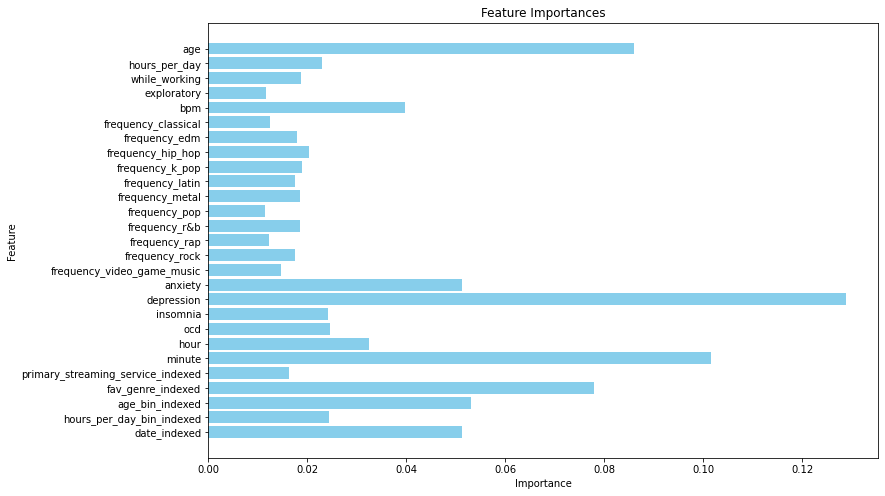

In [20]:
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt

# Define a RandomForest model
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=100, maxBins=50)

# Train the model
rf_model = rf.fit(assembled_train_df)

# Get feature importances
importances = rf_model.featureImportances

# Get feature names
feature_names = assembler.getInputCols()

# Combine feature names and importances into a list of tuples, converting importances to float
data = [(feature, float(importance)) for feature, importance in zip(feature_names, importances.toArray())]

# Create a PySpark DataFrame
importance_df = spark.createDataFrame(data, ["Feature", "Importance"])

# Filter features with importance greater than 0.01
important_features_df = importance_df.filter(col("Importance") > 0.01)

# Show the information on the new dataset
important_features_df.show()

# Convert PySpark DataFrame to Pandas DataFrame
importance_pdf = important_features_df.toPandas()

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_pdf["Feature"], importance_pdf["Importance"], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


In [21]:
# Extracted features into new dataframe
# List of important features to extract
important_features = [
    "age", "hours_per_day", "while_working", "bpm", "frequency_classical",
    "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin",
    "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b",
    "frequency_rock", "frequency_video_game_music", "anxiety", "depression",
    "insomnia", "ocd", "hour", "minute", "primary_streaming_service",
    "fav_genre", "age_bin", "hours_per_day_bin", "date"
]

# Add music_effects to the list of important features
important_features.append("music_effects")

# Extract the important features from the original DataFrame
extracted_df = df.select(*important_features)
# Print schema to understand the structure
extracted_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- hours_per_day: double (nullable = true)
 |-- while_working: integer (nullable = true)
 |-- bpm: double (nullable = true)
 |-- frequency_classical: integer (nullable = true)
 |-- frequency_edm: integer (nullable = true)
 |-- frequency_folk: integer (nullable = true)
 |-- frequency_hip_hop: integer (nullable = true)
 |-- frequency_latin: integer (nullable = true)
 |-- frequency_lofi: integer (nullable = true)
 |-- frequency_metal: integer (nullable = true)
 |-- frequency_pop: integer (nullable = true)
 |-- frequency_r&b: integer (nullable = true)
 |-- frequency_rock: integer (nullable = true)
 |-- frequency_video_game_music: integer (nullable = true)
 |-- anxiety: double (nullable = true)
 |-- depression: double (nullable = true)
 |-- insomnia: double (nullable = true)
 |-- ocd: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- primary_streaming_service: string (nullable = true)
 |-- fav

In [9]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Save DataFrame as CSV") \
    .getOrCreate()

# Save the DataFrame as a CSV file
file_path = "4extracted_df.csv"
extracted_df.write.mode("overwrite").option("header", "true").csv(file_path)

# Show the file path
print("CSV file saved at:", file_path)

CSV file saved at: 4extracted_df.csv


In [9]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Save and Read DataFrame as CSV") \
    .getOrCreate()

# Assuming extracted_df is already defined and you want to save it
file_path = "4extracted_df.csv"

# Save the DataFrame as a CSV file
extracted_df.write.mode("overwrite").option("header", "true").csv(file_path)

# Show the file path
print("CSV file saved at:", file_path)

# Read the CSV file back into a Spark DataFrame
extracted_df = spark.read.option("header", "true").csv(file_path)

# Show the schema and first few rows of the read-back DataFrame
extracted_df.printSchema()



CSV file saved at: 4extracted_df.csv
root
 |-- age: string (nullable = true)
 |-- hours_per_day: string (nullable = true)
 |-- while_working: string (nullable = true)
 |-- bpm: string (nullable = true)
 |-- frequency_classical: string (nullable = true)
 |-- frequency_edm: string (nullable = true)
 |-- frequency_folk: string (nullable = true)
 |-- frequency_hip_hop: string (nullable = true)
 |-- frequency_latin: string (nullable = true)
 |-- frequency_lofi: string (nullable = true)
 |-- frequency_metal: string (nullable = true)
 |-- frequency_pop: string (nullable = true)
 |-- frequency_r&b: string (nullable = true)
 |-- frequency_rock: string (nullable = true)
 |-- frequency_video_game_music: string (nullable = true)
 |-- anxiety: string (nullable = true)
 |-- depression: string (nullable = true)
 |-- insomnia: string (nullable = true)
 |-- ocd: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- minute: string (nullable = true)
 |-- primary_streaming_service: string (nul

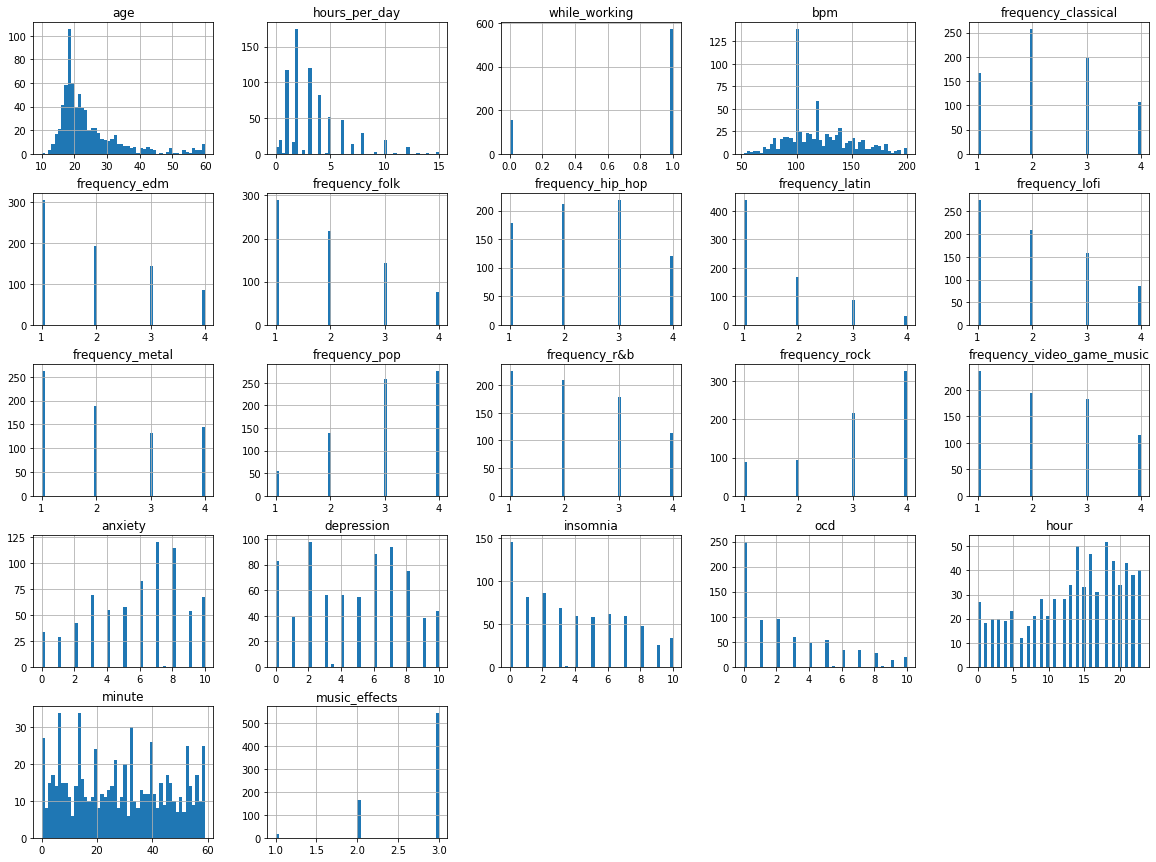

In [10]:
# Visualise distributions of selected features 
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
pandas_df = df.select(important_features).toPandas()

# Plot histograms of the features
pandas_df.hist(figsize=(20, 15), bins=50)
plt.show()


In [22]:
import pandas as pd
from pyspark.sql.functions import col, log, sqrt
from pyspark.sql import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Function to calculate skewness and kurtosis
def calculate_statistics(df: DataFrame, columns: list) -> pd.DataFrame:
    stats = {}
    for column in columns:
        col_data = df.select(col(column)).toPandas()
        stats[column] = {
            'skewness': skew(col_data.dropna()),
            'kurtosis': kurtosis(col_data.dropna())
        }
    return pd.DataFrame(stats).T

# New features df
df = extracted_df
# List of string columns to be indexed
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
# Initialize StringIndexer for each string column with handleInvalid='keep'
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Apply StringIndexer to transform string columns into indexed columns
pipeline_indexer = Pipeline(stages=indexers)
df_indexed = pipeline_indexer.fit(df).transform(df)

# Ensure all columns are correctly transformed
def transform_columns(df: DataFrame, transformation_func, suffix: str) -> DataFrame:
    transformed_cols = [transformation_func(col(c)).alias(f"{c}_{suffix}") for c in df.columns if c not in string_cols + ['music_effects']]
    return df.select(['music_effects'] + [f"{col}_indexed" for col in string_cols] + transformed_cols)

# Apply log and sqrt transformations
df_log_transformed = transform_columns(df_indexed, lambda c: log(c + 1), 'log')
df_sqrt_transformed = transform_columns(df_indexed, sqrt, 'sqrt')

# Extract relevant columns for comparison
numeric_columns = [col for col in df.columns if col not in string_cols + ['music_effects']]
original_stats = calculate_statistics(df_indexed, numeric_columns)
log_stats = calculate_statistics(df_log_transformed, [f"{col}_log" for col in numeric_columns])
sqrt_stats = calculate_statistics(df_sqrt_transformed, [f"{col}_sqrt" for col in numeric_columns])

# Print statistics
print("Original Data Statistics:")
print(original_stats)
print("\nLog-Transformed Data Statistics:")
print(log_stats)
print("\nSquare Root-Transformed Data Statistics:")
print(sqrt_stats)



Original Data Statistics:
                                          skewness                kurtosis
age                           [1.8895857044177138]    [3.6057917718498285]
hours_per_day                  [1.516473713303821]    [2.4660649929599288]
while_working                [-1.4126448280440336]  [-0.00443458980044209]
bpm                           [0.5779459632141106]  [-0.12198299206489782]
frequency_classical          [0.20584697166393687]   [-0.9837042719813489]
frequency_edm                 [0.5950379557774494]   [-0.9230320719250535]
frequency_folk                [0.5988432284183117]   [-0.8154313530521917]
frequency_hip_hop             [0.0876266545078173]   [-1.1425673133392718]
frequency_latin               [1.2665004966342674]    [0.5939484932438441]
frequency_lofi                [0.4968070382788795]   [-0.9731223155493645]
frequency_metal               [0.3831478025447569]   [-1.2720957706799887]
frequency_pop                [-0.6336414089562802]   [-0.5574416487122815]

In [ ]:
import pandas as pd
from pyspark.sql.functions import col, log, sqrt
from pyspark.sql import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, boxcox, yeojohnson
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Function to calculate skewness and kurtosis
def calculate_statistics(df: DataFrame, columns: list) -> pd.DataFrame:
    stats = {}
    for column in columns:
        col_data = df.select(col(column)).toPandas()
        stats[column] = {
            'skewness': skew(col_data.dropna()),
            'kurtosis': kurtosis(col_data.dropna())
        }
    return pd.DataFrame(stats).T

# New features df
df = extracted_df
# List of string columns to be indexed
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
# Initialize StringIndexer for each string column with handleInvalid='keep'
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Apply StringIndexer to transform string columns into indexed columns
pipeline_indexer = Pipeline(stages=indexers)
df_indexed = pipeline_indexer.fit(df).transform(df)

# Ensure all columns are correctly transformed
def transform_columns(df: DataFrame, transformation_func, suffix: str) -> DataFrame:
    transformed_cols = [transformation_func(col(c)).alias(f"{c}_{suffix}") for c in df.columns if c not in string_cols + ['music_effects']]
    return df.select(['music_effects'] + [f"{col}_indexed" for col in string_cols] + transformed_cols)

# Apply log and sqrt transformations
df_log_transformed = transform_columns(df_indexed, lambda c: log(c + 1), 'log')
df_sqrt_transformed = transform_columns(df_indexed, sqrt, 'sqrt')

# Apply Box-Cox and Yeo-Johnson transformations
def apply_statistical_transformation(df: DataFrame, columns: list, method='boxcox') -> pd.DataFrame:
    pandas_df = df.select(columns).toPandas()
    transformed_data = pd.DataFrame()
    for column in columns:
        if method == 'boxcox':
            transformed_data[f"{column}_boxcox"] = boxcox(pandas_df[column] + 1)[0]  # boxcox requires positive values
        elif method == 'yeojohnson':
            transformed_data[f"{column}_yeojohnson"] = yeojohnson(pandas_df[column] + 1)[0]
    return spark.createDataFrame(transformed_data)
numeric_columns = [col for col in df.columns if col not in string_cols + ['music_effects']]
boxcox_transformed_df = apply_statistical_transformation(df_indexed, numeric_columns, method='boxcox')
yeojohnson_transformed_df = apply_statistical_transformation(df_indexed, numeric_columns, method='yeojohnson')

# Calculate statistics for Box-Cox and Yeo-Johnson transformations
boxcox_stats = calculate_statistics(boxcox_transformed_df, [f"{col}_boxcox" for col in numeric_columns])
yeojohnson_stats = calculate_statistics(yeojohnson_transformed_df, [f"{col}_yeojohnson" for col in numeric_columns])

# Print statistics
print("Original Data Statistics:")
print(original_stats)
print("\nLog-Transformed Data Statistics:")
print(log_stats)
print("\nSquare Root-Transformed Data Statistics:")
print(sqrt_stats)
print("\nBox-Cox Transformed Data Statistics:")
print(boxcox_stats)
print("\nYeo-Johnson Transformed Data Statistics:")
print(yeojohnson_stats)

# Function to visualize distributions before and after transformations
def plot_distributions(original_df, transformed_df, transformation_name):
    for column in numeric_columns:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(original_df.select(col(column)).toPandas().dropna(), kde=True)
        plt.title(f'Original: {column}')
        plt.subplot(1, 2, 2)
        sns.histplot(transformed_df.select(col(f"{column}_{transformation_name}")).toPandas().dropna(), kde=True)
        plt.title(f'{transformation_name}: {column}')
        plt.show()

# Plot distributions
plot_distributions(df_indexed, df_log_transformed, 'log')
plot_distributions(df_indexed, df_sqrt_transformed, 'sqrt')
plot_distributions(df_indexed, boxcox_transformed_df, 'boxcox')
plot_distributions(df_indexed, yeojohnson_transformed_df, 'yeojohnson')


In [ ]:
import pandas as pd
from pyspark.sql.functions import col, log1p, sqrt
from pyspark.sql import DataFrame
from pyspark.sql.types import DoubleType
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson, skew, kurtosis
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Function to calculate skewness and kurtosis
def calculate_statistics(df: DataFrame, columns: list) -> pd.DataFrame:
    stats = {}
    for column in columns:
        col_data = df.select(col(column)).toPandas()
        stats[column] = {
            'skewness': skew(col_data.dropna()),
            'kurtosis': kurtosis(col_data.dropna())
        }
    return pd.DataFrame(stats).T

# Function to apply Yeo-Johnson transformation
def apply_yeojohnson(df: DataFrame, columns: list) -> DataFrame:
    pandas_df = df.select(columns).toPandas()
    transformed_data = pd.DataFrame()
    for column in columns:
        transformed_data[f"{column}_yeojohnson"] = yeojohnson(pandas_df[column])[0]
    return spark.createDataFrame(transformed_data)

# Ensure numeric columns are of DoubleType for transformations
df = extracted_df
df = df.withColumn("age", col("age").cast(DoubleType()))\
       .withColumn("hours_per_day", col("hours_per_day").cast(DoubleType()))\
       .withColumn("bpm", col("bpm").cast(DoubleType()))\
       .withColumn("frequency_classical", col("frequency_classical").cast(DoubleType()))\
       .withColumn("frequency_edm", col("frequency_edm").cast(DoubleType()))\
       .withColumn("frequency_folk", col("frequency_folk").cast(DoubleType()))\
       .withColumn("frequency_hip_hop", col("frequency_hip_hop").cast(DoubleType()))\
       .withColumn("frequency_latin", col("frequency_latin").cast(DoubleType()))\
       .withColumn("frequency_lofi", col("frequency_lofi").cast(DoubleType()))\
       .withColumn("frequency_metal", col("frequency_metal").cast(DoubleType()))\
       .withColumn("frequency_pop", col("frequency_pop").cast(DoubleType()))\
       .withColumn("frequency_r&b", col("frequency_r&b").cast(DoubleType()))\
       .withColumn("frequency_rock", col("frequency_rock").cast(DoubleType()))\
       .withColumn("frequency_video_game_music", col("frequency_video_game_music").cast(DoubleType()))\
       .withColumn("anxiety", col("anxiety").cast(DoubleType()))\
       .withColumn("depression", col("depression").cast(DoubleType()))\
       .withColumn("insomnia", col("insomnia").cast(DoubleType()))\
       .withColumn("ocd", col("ocd").cast(DoubleType()))

# List of string columns to be indexed
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
# Initialize StringIndexer for each string column with handleInvalid='keep'
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Apply StringIndexer to transform string columns into indexed columns
pipeline_indexer = Pipeline(stages=indexers)
df_indexed = pipeline_indexer.fit(df).transform(df)

# Ensure all columns are correctly transformed
def transform_columns(df: DataFrame, transformation_func, suffix: str) -> DataFrame:
    transformed_cols = [transformation_func(col(c)).alias(f"{c}_{suffix}") for c in df.columns if c not in string_cols + ['music_effects']]
    return df.select(['music_effects'] + [f"{col}_indexed" for col in string_cols] + transformed_cols)

# Apply log1p and sqrt transformations
df_log1p_transformed = transform_columns(df_indexed, log1p, 'log1p')
df_sqrt_transformed = transform_columns(df_indexed, sqrt, 'sqrt')

# Apply Yeo-Johnson transformation
yeojohnson_transformed_df = apply_yeojohnson(df_indexed, numeric_columns)

# Combine the transformed columns
transformed_df = df_log1p_transformed.join(df_sqrt_transformed, "music_effects", "outer")
transformed_df = transformed_df.join(yeojohnson_transformed_df, "music_effects", "outer")

# Ensure to add back the indexed string columns and music_effects
transformed_df = df_indexed.select(['music_effects'] + [f"{col}_indexed" for col in string_cols]).join(transformed_df, "music_effects", "outer")

# Extract relevant columns for comparison
numeric_columns = [col for col in df.columns if col not in string_cols + ['music_effects']]
original_stats = calculate_statistics(df_indexed, numeric_columns)
log1p_stats = calculate_statistics(df_log1p_transformed, [f"{col}_log1p" for col in numeric_columns])
sqrt_stats = calculate_statistics(df_sqrt_transformed, [f"{col}_sqrt" for col in numeric_columns])
yeojohnson_stats = calculate_statistics(yeojohnson_transformed_df, [f"{col}_yeojohnson" for col in numeric_columns])

# Print statistics
print("Original Data Statistics:")
print(original_stats)
print("\nLog1p-Transformed Data Statistics:")
print(log1p_stats)
print("\nSquare Root-Transformed Data Statistics:")
print(sqrt_stats)
print("\nYeo-Johnson Transformed Data Statistics:")
print(yeojohnson_stats)

In [24]:
#4.2 transformation
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, IntegerType
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson, boxcox, skew, kurtosis
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Function to calculate skewness and kurtosis
def calculate_statistics(df, columns):
    stats = {}
    for column in columns:
        col_data = df.select(col(column)).toPandas()
        stats[column] = {
            'skewness': skew(col_data.dropna()),
            'kurtosis': kurtosis(col_data.dropna())
        }
    return pd.DataFrame(stats).T

# Function to apply Yeo-Johnson transformation
def apply_yeojohnson(df, columns):
    numeric_df = df.select(columns + ['music_effects']).toPandas()  # Convert to Pandas DataFrame
    transformed_data = pd.DataFrame()
    transformed_data['music_effects'] = numeric_df['music_effects']
    for column in columns:
        transformed_data[f"{column}_yeojohnson"] = yeojohnson(numeric_df[column].astype(float))[0]
    return spark.createDataFrame(transformed_data)

# Function to apply Box-Cox transformation
def apply_boxcox(df, columns):
    pandas_df = df.select(columns + ['music_effects']).toPandas()
    transformed_data = pd.DataFrame()
    transformed_data['music_effects'] = pandas_df['music_effects']
    for column in columns:
        transformed_data[f"{column}_boxcox"], _ = boxcox(pandas_df[column] + 1)  # Adding 1 to ensure all values are positive
    return spark.createDataFrame(transformed_data)

# Ensure numeric columns are of DoubleType for transformations
df = extracted_df
df = df.withColumn("age", col("age").cast(DoubleType()))\
       .withColumn("hours_per_day", col("hours_per_day").cast(DoubleType()))\
       .withColumn("bpm", col("bpm").cast(DoubleType()))\
       .withColumn("frequency_classical", col("frequency_classical").cast(DoubleType()))\
       .withColumn("frequency_edm", col("frequency_edm").cast(DoubleType()))\
       .withColumn("frequency_folk", col("frequency_folk").cast(DoubleType()))\
       .withColumn("frequency_hip_hop", col("frequency_hip_hop").cast(DoubleType()))\
       .withColumn("frequency_latin", col("frequency_latin").cast(DoubleType()))\
       .withColumn("frequency_lofi", col("frequency_lofi").cast(DoubleType()))\
       .withColumn("frequency_metal", col("frequency_metal").cast(DoubleType()))\
       .withColumn("frequency_pop", col("frequency_pop").cast(DoubleType()))\
       .withColumn("frequency_r&b", col("frequency_r&b").cast(DoubleType()))\
       .withColumn("frequency_rock", col("frequency_rock").cast(DoubleType()))\
       .withColumn("frequency_video_game_music", col("frequency_video_game_music").cast(DoubleType()))\
       .withColumn("anxiety", col("anxiety").cast(IntegerType()))\
       .withColumn("depression", col("depression").cast(IntegerType()))\
       .withColumn("insomnia", col("insomnia").cast(IntegerType()))\
       .withColumn("ocd", col("ocd").cast(IntegerType()))\
       .withColumn("music_effects", col("music_effects").cast(IntegerType()))

# List of string columns to be indexed
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
# Initialize StringIndexer for each string column with handleInvalid='keep'
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Apply StringIndexer to transform string columns into indexed columns
pipeline_indexer = Pipeline(stages=indexers)
df_indexed = pipeline_indexer.fit(df).transform(df)

# Apply Yeo-Johnson transformation to the relevant numeric columns
numeric_columns = [col for col in df.columns if col not in string_cols + ['music_effects', 'hours_per_day', 'bpm']]
yeojohnson_transformed_df = apply_yeojohnson(df_indexed, numeric_columns)

# Apply Box-Cox transformation to hours_per_day and bpm
boxcox_transformed_df = apply_boxcox(df_indexed, ['hours_per_day', 'bpm'])

# Calculate statistics
original_stats = calculate_statistics(df_indexed, numeric_columns + ['hours_per_day', 'bpm'])
yeojohnson_stats = calculate_statistics(yeojohnson_transformed_df, [f"{col}_yeojohnson" for col in numeric_columns])
boxcox_stats = calculate_statistics(boxcox_transformed_df, ['hours_per_day_boxcox', 'bpm_boxcox'])

# Print statistics
print("Original Data Statistics:")
print(original_stats)
print("\nYeo-Johnson Transformed Data Statistics:")
print(yeojohnson_stats)
print("\nBox-Cox Transformed Data Statistics:")
print(boxcox_stats)

# Concatenate statistics dataframes
combined_stats = pd.concat([original_stats, yeojohnson_stats, boxcox_stats], axis=1)

# Print combined statistics
print("Combined Statistics:")
print(combined_stats)



Original Data Statistics:
                                           skewness                kurtosis
age                            [1.8895857044177138]    [3.6057917718498285]
while_working                 [-1.4126448280440336]  [-0.00443458980044209]
frequency_classical           [0.20584697166393687]   [-0.9837042719813489]
frequency_edm                  [0.5950379557774494]   [-0.9230320719250535]
frequency_folk                 [0.5988432284183117]   [-0.8154313530521917]
frequency_hip_hop              [0.0876266545078173]   [-1.1425673133392718]
frequency_latin                [1.2665004966342674]    [0.5939484932438441]
frequency_lofi                 [0.4968070382788795]   [-0.9731223155493645]
frequency_metal                [0.3831478025447569]   [-1.2720957706799887]
frequency_pop                 [-0.6336414089562802]   [-0.5574416487122815]
frequency_r&b                 [0.28379711011024733]    [-1.163480028265298]
frequency_rock                [-0.8235623678229196]   [-0.5425

### 4.2 joining back the transfomed data together 

In [25]:
# Concatenate statistics dataframes
combined_stats = pd.concat([original_stats, yeojohnson_stats, boxcox_stats], axis=1)

# Join the transformed dataframes with the original dataframe
combined_transformed_df = extracted_df

# Rename columns to remove suffixes
for column in numeric_columns:
    combined_transformed_df = combined_transformed_df.withColumn(column, col(column))
for column in ['hours_per_day', 'bpm']:
    combined_transformed_df = combined_transformed_df.withColumn(column, col(column))

# Include string columns
for column in string_cols:
    combined_transformed_df = combined_transformed_df.withColumn(column, col(column))

# Show the combined transformed dataframe with the selected columns
#combined_transformed_df.show()

# Print the schema of the combined transformed dataframe
combined_transformed_df.printSchema()



root
 |-- age: integer (nullable = true)
 |-- hours_per_day: double (nullable = true)
 |-- while_working: integer (nullable = true)
 |-- bpm: double (nullable = true)
 |-- frequency_classical: integer (nullable = true)
 |-- frequency_edm: integer (nullable = true)
 |-- frequency_folk: integer (nullable = true)
 |-- frequency_hip_hop: integer (nullable = true)
 |-- frequency_latin: integer (nullable = true)
 |-- frequency_lofi: integer (nullable = true)
 |-- frequency_metal: integer (nullable = true)
 |-- frequency_pop: integer (nullable = true)
 |-- frequency_r&b: integer (nullable = true)
 |-- frequency_rock: integer (nullable = true)
 |-- frequency_video_game_music: integer (nullable = true)
 |-- anxiety: double (nullable = true)
 |-- depression: double (nullable = true)
 |-- insomnia: double (nullable = true)
 |-- ocd: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- primary_streaming_service: string (nullable = true)
 |-- fav

# 6

In [32]:
# #Multinomnial logistic regression
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
# from pyspark.ml import Pipeline
# import pandas as pd

# # List of feature columns
# feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical", 
#                    "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin", 
#                    "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b", 
#                    "frequency_rock", "frequency_video_game_music", "anxiety", "depression", 
#                    "insomnia", "ocd", "hour", "minute"]

# # Index and encode string columns
# string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
# indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]
# encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# # Assemble all features into a single vector
# assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")
# # Define the Logistic Regression model
# lr = LogisticRegression(labelCol="music_effects", featuresCol="features", maxIter=100, family="multinomial")
# # Create the pipeline
# pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])
# # Train-test split
# train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)
# # Train the model
# lr_model = pipeline.fit(train_df)
# # Make predictions
# predictions = lr_model.transform(test_df)
# # Evaluate the model
# evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="accuracy")
# accuracy = evaluator.evaluate(predictions)
# print(f"Multinomial Logistic Regression Accuracy: {accuracy}")
# # Extract coefficients and intercepts
# coefficient_matrix = lr_model.stages[-1].coefficientMatrix
# intercept_vector = lr_model.stages[-1].interceptVector

# # Get input columns after one-hot encoding
# assembler_features = assembler.getInputCols()

# # Verify the shape of the coefficient matrix
# print(f"Shape of coefficient matrix: {coefficient_matrix.toArray().shape}")

# # Create a list of feature names
# expanded_feature_columns = []
# for col in feature_columns:
#     expanded_feature_columns.append(col)
# for col in string_cols:
#     # We need to know the actual number of categories for each column
#     one_hot_size = train_df.select(f"{col}_vec").head()[f"{col}_vec"].size
#     for i in range(one_hot_size):
#         expanded_feature_columns.append(f"{col}_vec_{i}")
# # Verify the length of expanded feature columns
# print(f"Number of expanded feature columns: {len(expanded_feature_columns)}")
# # Ensure the number of columns match
# assert coefficient_matrix.toArray().shape[1] == len(expanded_feature_columns)
# # Create DataFrame of coefficients for each feature and each class
# coefficients_df = pd.DataFrame(coefficient_matrix.toArray(), columns=expanded_feature_columns)
# coefficients_df['class'] = range(coefficient_matrix.toArray().shape[0])
# coefficients_df = coefficients_df.melt(id_vars=['class'], var_name='Feature', value_name='Coefficient')

# print("Feature Coefficients:")
# print(coefficients_df)
# 


In [30]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Define feature columns and string columns
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical", 
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin", 
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b", 
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression", 
                   "insomnia", "ocd", "hour", "minute"]
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']

# Index and encode string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")

# Define the Logistic Regression model
lr = LogisticRegression(labelCol="music_effects", featuresCol="features", maxIter=100, family="multinomial")

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)

# Train the model
lr_model = pipeline.fit(train_df)

# Make predictions
predictions = lr_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Multinomial Logistic Regression - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


Multinomial Logistic Regression - Accuracy: 0.6581196581196581, Precision: 0.612651898366184, Recall: 0.6581196581196582


In [31]:

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

# Index string columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Assemble features into a vector
feature_columns = [col for col in combined_transformed_df.columns if col not in string_cols + ['music_effects']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the RandomForest model
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=100)

# Create the pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)

# Train the model
rf_model = pipeline.fit(train_df)

# Make predictions
predictions = rf_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Random Forest - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")



Random Forest - Accuracy: 0.7521367521367521, Precision: 0.5657096939148221, Recall: 0.7521367521367521


In [33]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the KMeans model
kmeans = KMeans(featuresCol="features", k=3)

# Create the pipeline
pipeline = Pipeline(stages=indexers + [assembler, kmeans])

# Train the model
kmeans_model = pipeline.fit(combined_transformed_df)

# Make predictions
predictions = kmeans_model.transform(combined_transformed_df)

# Evaluate the model
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"K-Means Silhouette Score: {silhouette}")


K-Means Silhouette Score: 0.4721198334397441


## 7.1

In [36]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define string columns and feature columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical", 
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin", 
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b", 
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression", 
                   "insomnia", "ocd", "hour", "minute"]

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# One-hot encode indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")

# Define the RandomForest model
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=100)

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)

# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 200])
             .addGrid(rf.maxDepth, [5, 10, 20])
             .addGrid(rf.minInstancesPerNode, [1, 5, 10])
             .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt', 'log2'])
             .build())

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="accuracy")

# Define the cross-validator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Train the model using cross-validation
cv_model = cv.fit(train_df)

# Get the best model
best_model = cv_model.bestModel

# Print the best parameters
print(f"Best numTrees: {best_model.stages[-1].getOrDefault('numTrees')}")
print(f"Best maxDepth: {best_model.stages[-1].getOrDefault('maxDepth')}")
print(f"Best minInstancesPerNode: {best_model.stages[-1].getOrDefault('minInstancesPerNode')}")
print(f"Best featureSubsetStrategy: {best_model.stages[-1].getOrDefault('featureSubsetStrategy')}")

# Evaluate the best model on the test set
test_predictions = best_model.transform(test_df)
accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {accuracy}")



24/05/23 20:20:05 WARN DAGScheduler: Broadcasting large task binary with size 1004.5 KiB
24/05/23 20:20:07 WARN DAGScheduler: Broadcasting large task binary with size 1004.5 KiB
24/05/23 20:20:09 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB
24/05/23 20:20:21 WARN DAGScheduler: Broadcasting large task binary with size 1004.5 KiB
24/05/23 20:20:21 WARN DAGScheduler: Broadcasting large task binary with size 1143.1 KiB
24/05/23 20:20:21 WARN DAGScheduler: Broadcasting large task binary with size 1261.1 KiB
24/05/23 20:20:22 WARN DAGScheduler: Broadcasting large task binary with size 1275.0 KiB
24/05/23 20:20:22 WARN DAGScheduler: Broadcasting large task binary with size 1290.3 KiB
24/05/23 20:20:22 WARN DAGScheduler: Broadcasting large task binary with size 1243.8 KiB
24/05/23 20:20:22 WARN DAGScheduler: Broadcasting large task binary with size 1140.3 KiB
24/05/23 20:20:22 WARN DAGScheduler: Broadcasting large task binary with size 1130.3 KiB
24/05/23 20:20:24 WAR

24/05/23 20:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1497.9 KiB
24/05/23 20:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1434.8 KiB
24/05/23 20:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1094.9 KiB
24/05/23 20:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1060.9 KiB
24/05/23 20:21:33 WARN DAGScheduler: Broadcasting large task binary with size 1219.4 KiB
24/05/23 20:21:33 WARN DAGScheduler: Broadcasting large task binary with size 1316.8 KiB
24/05/23 20:21:33 WARN DAGScheduler: Broadcasting large task binary with size 1267.1 KiB
24/05/23 20:21:33 WARN DAGScheduler: Broadcasting large task binary with size 1186.6 KiB
24/05/23 20:21:33 WARN DAGScheduler: Broadcasting large task binary with size 1151.5 KiB
24/05/23 20:21:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.7 KiB
24/05/23 20:21:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.7 KiB
24/05/23 20:21:46 WAR

24/05/23 20:22:42 WARN DAGScheduler: Broadcasting large task binary with size 1236.9 KiB
24/05/23 20:22:43 WARN DAGScheduler: Broadcasting large task binary with size 1726.7 KiB
24/05/23 20:22:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 20:22:43 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 20:22:44 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/23 20:22:44 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/05/23 20:22:45 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/05/23 20:22:45 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/05/23 20:22:46 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/05/23 20:22:46 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/05/23 20:22:46 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/05/23 20:22:47 WARN DAGScheduler: Broadcastin

24/05/23 20:23:44 WARN DAGScheduler: Broadcasting large task binary with size 1261.2 KiB
24/05/23 20:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1031.8 KiB
24/05/23 20:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1349.8 KiB
24/05/23 20:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1678.9 KiB
24/05/23 20:24:09 WARN DAGScheduler: Broadcasting large task binary with size 2004.3 KiB
24/05/23 20:24:10 WARN DAGScheduler: Broadcasting large task binary with size 1556.3 KiB
24/05/23 20:24:11 WARN DAGScheduler: Broadcasting large task binary with size 1031.8 KiB
24/05/23 20:24:11 WARN DAGScheduler: Broadcasting large task binary with size 1349.8 KiB
24/05/23 20:24:12 WARN DAGScheduler: Broadcasting large task binary with size 1678.9 KiB
24/05/23 20:24:12 WARN DAGScheduler: Broadcasting large task binary with size 2004.3 KiB
24/05/23 20:24:12 WARN DAGScheduler: Broadcasting large task binary with size 1556.3 KiB
24/05/23 20:24:14 WAR

24/05/23 20:25:15 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/23 20:25:16 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/05/23 20:25:16 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/23 20:25:17 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 20:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1325.2 KiB
24/05/23 20:25:19 WARN DAGScheduler: Broadcasting large task binary with size 1868.6 KiB
24/05/23 20:25:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/23 20:25:20 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/05/23 20:25:20 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/23 20:25:21 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 20:25:22 WARN DAGScheduler: Broadcasting large task binary with size 1231.2 KiB
24/05/23 20:25:23 WARN DAGScheduler: Broadcas

24/05/23 20:26:05 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/05/23 20:26:05 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/05/23 20:26:06 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/05/23 20:26:06 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/05/23 20:26:06 WARN DAGScheduler: Broadcasting large task binary with size 1908.6 KiB
24/05/23 20:26:07 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/23 20:26:09 WARN DAGScheduler: Broadcasting large task binary with size 1358.2 KiB
24/05/23 20:26:09 WARN DAGScheduler: Broadcasting large task binary with size 1841.7 KiB
24/05/23 20:26:09 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 20:26:10 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/05/23 20:26:10 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/05/23 20:26:11 WARN DAGScheduler: Broadcas

24/05/23 20:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1277.9 KiB
24/05/23 20:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1586.9 KiB
24/05/23 20:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1889.8 KiB
24/05/23 20:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB
24/05/23 20:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1233.1 KiB
24/05/23 20:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1537.3 KiB
24/05/23 20:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1841.9 KiB
24/05/23 20:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1426.1 KiB
24/05/23 20:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1141.2 KiB
24/05/23 20:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1338.2 KiB
24/05/23 20:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1491.9 KiB
24/05/23 20:27:38 WAR

24/05/23 20:28:43 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/23 20:28:43 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/23 20:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1336.5 KiB
24/05/23 20:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1793.2 KiB
24/05/23 20:28:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 20:28:46 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/23 20:28:47 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 20:28:47 WARN DAGScheduler: Broadcasting large task binary with size 1628.2 KiB
24/05/23 20:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1336.5 KiB
24/05/23 20:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1793.2 KiB
24/05/23 20:28:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 20:28:50 WARN DAGScheduler: Br

24/05/23 20:29:31 WARN DAGScheduler: Broadcasting large task binary with size 1336.5 KiB
24/05/23 20:29:31 WARN DAGScheduler: Broadcasting large task binary with size 1793.2 KiB
24/05/23 20:29:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 20:29:32 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/23 20:29:32 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 20:29:33 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/23 20:29:33 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 20:29:33 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 20:29:33 WARN DAGScheduler: Broadcasting large task binary with size 1528.3 KiB
24/05/23 20:29:34 WARN DAGScheduler: Broadcasting large task binary with size 1747.2 KiB
24/05/23 20:29:35 WARN DAGScheduler: Broadcasting large task binary with size 1164.2 KiB
24/05/23 20:29:36 WARN DAGScheduler: Br

24/05/23 20:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1009.8 KiB
24/05/23 20:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1310.2 KiB
24/05/23 20:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1621.5 KiB
24/05/23 20:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1932.2 KiB
24/05/23 20:31:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 20:31:06 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/23 20:31:06 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/23 20:31:06 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/05/23 20:31:06 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/23 20:31:07 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 20:31:07 WARN DAGScheduler: Broadcasting large task binary with size 1885.1 KiB
24/05/23 20:31:07 WARN DAGScheduler: Br

24/05/23 20:32:08 WARN DAGScheduler: Broadcasting large task binary with size 1175.0 KiB
24/05/23 20:32:08 WARN DAGScheduler: Broadcasting large task binary with size 1536.8 KiB
24/05/23 20:32:09 WARN DAGScheduler: Broadcasting large task binary with size 1906.9 KiB
24/05/23 20:32:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 20:32:09 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 20:32:10 WARN DAGScheduler: Broadcasting large task binary with size 1455.4 KiB
24/05/23 20:32:12 WARN DAGScheduler: Broadcasting large task binary with size 1187.2 KiB
24/05/23 20:32:12 WARN DAGScheduler: Broadcasting large task binary with size 1477.9 KiB
24/05/23 20:32:12 WARN DAGScheduler: Broadcasting large task binary with size 1722.2 KiB
24/05/23 20:32:13 WARN DAGScheduler: Broadcasting large task binary with size 1872.1 KiB
24/05/23 20:32:13 WARN DAGScheduler: Broadcasting large task binary with size 1678.4 KiB
24/05/23 20:32:13 WARN DAGS

24/05/23 20:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1536.8 KiB
24/05/23 20:32:53 WARN DAGScheduler: Broadcasting large task binary with size 1906.9 KiB
24/05/23 20:32:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 20:32:53 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 20:32:54 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/23 20:32:54 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 20:32:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 20:32:54 WARN DAGScheduler: Broadcasting large task binary with size 1724.0 KiB
24/05/23 20:32:54 WARN DAGScheduler: Broadcasting large task binary with size 1271.7 KiB
24/05/23 20:32:55 WARN DAGScheduler: Broadcasting large task binary with size 1615.1 KiB
24/05/23 20:32:57 WARN DAGScheduler: Broadcasting large task binary with size 1187.2 KiB
24/05/23 20:32:57 WARN DAGScheduler:

24/05/23 20:34:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 20:34:25 WARN DAGScheduler: Broadcasting large task binary with size 1285.7 KiB
24/05/23 20:34:25 WARN DAGScheduler: Broadcasting large task binary with size 1601.3 KiB
24/05/23 20:34:25 WARN DAGScheduler: Broadcasting large task binary with size 1915.4 KiB
24/05/23 20:34:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 20:34:26 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/23 20:34:26 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/23 20:34:26 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/05/23 20:34:26 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/23 20:34:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 20:34:26 WARN DAGScheduler: Broadcasting large task binary with size 1773.4 KiB
24/05/23 20:34:27 WARN DAGScheduler: Broad

24/05/23 20:35:31 WARN DAGScheduler: Broadcasting large task binary with size 1728.5 KiB
24/05/23 20:35:32 WARN DAGScheduler: Broadcasting large task binary with size 1812.8 KiB
24/05/23 20:35:32 WARN DAGScheduler: Broadcasting large task binary with size 1675.6 KiB
24/05/23 20:35:32 WARN DAGScheduler: Broadcasting large task binary with size 1094.5 KiB
24/05/23 20:35:34 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
24/05/23 20:35:34 WARN DAGScheduler: Broadcasting large task binary with size 1244.4 KiB
24/05/23 20:35:34 WARN DAGScheduler: Broadcasting large task binary with size 1402.3 KiB
24/05/23 20:35:34 WARN DAGScheduler: Broadcasting large task binary with size 1430.7 KiB
24/05/23 20:35:34 WARN DAGScheduler: Broadcasting large task binary with size 1250.0 KiB
24/05/23 20:35:36 WARN DAGScheduler: Broadcasting large task binary with size 1311.0 KiB
24/05/23 20:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1841.1 KiB
24/05/23 20:35:37 WAR

24/05/23 20:36:16 WARN DAGScheduler: Broadcasting large task binary with size 1675.6 KiB
24/05/23 20:36:16 WARN DAGScheduler: Broadcasting large task binary with size 1129.2 KiB
24/05/23 20:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1104.9 KiB
24/05/23 20:36:18 WARN DAGScheduler: Broadcasting large task binary with size 1187.7 KiB
24/05/23 20:36:18 WARN DAGScheduler: Broadcasting large task binary with size 1484.1 KiB
24/05/23 20:36:19 WARN DAGScheduler: Broadcasting large task binary with size 1728.5 KiB
24/05/23 20:36:19 WARN DAGScheduler: Broadcasting large task binary with size 1812.8 KiB
24/05/23 20:36:19 WARN DAGScheduler: Broadcasting large task binary with size 1675.6 KiB
24/05/23 20:36:20 WARN DAGScheduler: Broadcasting large task binary with size 1129.2 KiB
24/05/23 20:36:20 WARN DAGScheduler: Broadcasting large task binary with size 1104.9 KiB
24/05/23 20:36:22 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
24/05/23 20:36:22 WAR

Best numTrees: 50
Best maxDepth: 20
Best minInstancesPerNode: 1
Best featureSubsetStrategy: log2
Test Accuracy: 0.7435897435897436


24/05/23 20:36:26 WARN DAGScheduler: Broadcasting large task binary with size 1382.7 KiB


In [37]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define string columns and feature columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical", 
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin", 
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b", 
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression", 
                   "insomnia", "ocd", "hour", "minute"]

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# One-hot encode indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")

# Define the RandomForest model
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=100)

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.7, 0.3], seed=42)

# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 200])
             .addGrid(rf.maxDepth, [5, 10, 20])
             .addGrid(rf.minInstancesPerNode, [1, 5, 10])
             .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt', 'log2'])
             .build())

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="accuracy")

# Define the cross-validator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Train the model using cross-validation
cv_model = cv.fit(train_df)

# Get the best model
best_model = cv_model.bestModel

# Print the best parameters
print(f"Best numTrees: {best_model.stages[-1].getOrDefault('numTrees')}")
print(f"Best maxDepth: {best_model.stages[-1].getOrDefault('maxDepth')}")
print(f"Best minInstancesPerNode: {best_model.stages[-1].getOrDefault('minInstancesPerNode')}")
print(f"Best featureSubsetStrategy: {best_model.stages[-1].getOrDefault('featureSubsetStrategy')}")

# Evaluate the best model on the test set
test_predictions = best_model.transform(test_df)
accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {accuracy}")


24/05/23 20:39:36 WARN DAGScheduler: Broadcasting large task binary with size 1062.4 KiB
24/05/23 20:39:36 WARN DAGScheduler: Broadcasting large task binary with size 1134.7 KiB
24/05/23 20:39:36 WARN DAGScheduler: Broadcasting large task binary with size 1166.0 KiB
24/05/23 20:39:37 WARN DAGScheduler: Broadcasting large task binary with size 1183.8 KiB
24/05/23 20:39:37 WARN DAGScheduler: Broadcasting large task binary with size 1038.6 KiB
24/05/23 20:39:39 WARN DAGScheduler: Broadcasting large task binary with size 1062.4 KiB
24/05/23 20:39:39 WARN DAGScheduler: Broadcasting large task binary with size 1134.7 KiB
24/05/23 20:39:39 WARN DAGScheduler: Broadcasting large task binary with size 1166.0 KiB
24/05/23 20:39:39 WARN DAGScheduler: Broadcasting large task binary with size 1183.8 KiB
24/05/23 20:39:40 WARN DAGScheduler: Broadcasting large task binary with size 1038.6 KiB
24/05/23 20:39:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.3 KiB
24/05/23 20:39:42 WAR

24/05/23 20:41:12 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 20:41:12 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/05/23 20:41:13 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 20:41:14 WARN DAGScheduler: Broadcasting large task binary with size 1238.2 KiB
24/05/23 20:41:14 WARN DAGScheduler: Broadcasting large task binary with size 1718.0 KiB
24/05/23 20:41:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 20:41:15 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 20:41:16 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/05/23 20:41:16 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 20:41:18 WARN DAGScheduler: Broadcasting large task binary with size 1190.4 KiB
24/05/23 20:41:18 WARN DAGScheduler: Broadcasting large task binary with size 1642.4 KiB
24/05/23 20:41:18 WARN DAGScheduler: Broad

24/05/23 20:41:58 WARN DAGScheduler: Broadcasting large task binary with size 2006.7 KiB
24/05/23 20:41:59 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 20:41:59 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 20:41:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/23 20:42:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 20:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1553.0 KiB
24/05/23 20:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1029.8 KiB
24/05/23 20:42:01 WARN DAGScheduler: Broadcasting large task binary with size 1575.8 KiB
24/05/23 20:42:02 WARN DAGScheduler: Broadcasting large task binary with size 1230.2 KiB
24/05/23 20:42:02 WARN DAGScheduler: Broadcasting large task binary with size 1621.9 KiB
24/05/23 20:42:03 WARN DAGScheduler: Broadcasting large task binary with size 2006.7 KiB
24/05/23 20:42:03 WARN DAGSchedul

24/05/23 20:43:34 WARN DAGScheduler: Broadcasting large task binary with size 2016.8 KiB
24/05/23 20:43:35 WARN DAGScheduler: Broadcasting large task binary with size 1211.7 KiB
24/05/23 20:43:35 WARN DAGScheduler: Broadcasting large task binary with size 1491.3 KiB
24/05/23 20:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1759.0 KiB
24/05/23 20:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1999.7 KiB
24/05/23 20:43:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 20:43:36 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 20:43:36 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 20:43:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 20:43:37 WARN DAGScheduler: Broadcasting large task binary with size 1990.3 KiB
24/05/23 20:43:37 WARN DAGScheduler: Broadcasting large task binary with size 1680.0 KiB
24/05/23 20:43:37 WARN DAGSchedul

24/05/23 20:44:40 WARN DAGScheduler: Broadcasting large task binary with size 1320.8 KiB
24/05/23 20:44:40 WARN DAGScheduler: Broadcasting large task binary with size 1345.2 KiB
24/05/23 20:44:41 WARN DAGScheduler: Broadcasting large task binary with size 1178.2 KiB
24/05/23 20:44:43 WARN DAGScheduler: Broadcasting large task binary with size 1208.7 KiB
24/05/23 20:44:43 WARN DAGScheduler: Broadcasting large task binary with size 1668.5 KiB
24/05/23 20:44:43 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 20:44:44 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/05/23 20:44:44 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/05/23 20:44:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/23 20:44:45 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/05/23 20:44:45 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/05/23 20:44:46 WARN DAGScheduler: Br

24/05/23 20:45:21 WARN DAGScheduler: Broadcasting large task binary with size 1064.7 KiB
24/05/23 20:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1168.2 KiB
24/05/23 20:45:23 WARN DAGScheduler: Broadcasting large task binary with size 1320.7 KiB
24/05/23 20:45:23 WARN DAGScheduler: Broadcasting large task binary with size 1345.2 KiB
24/05/23 20:45:23 WARN DAGScheduler: Broadcasting large task binary with size 1178.2 KiB
24/05/23 20:45:35 WARN DAGScheduler: Broadcasting large task binary with size 1021.8 KiB
24/05/23 20:45:36 WARN DAGScheduler: Broadcasting large task binary with size 1021.8 KiB
24/05/23 20:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1021.8 KiB
24/05/23 20:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1150.7 KiB
24/05/23 20:45:49 WARN DAGScheduler: Broadcasting large task binary with size 1257.6 KiB
24/05/23 20:45:49 WARN DAGScheduler: Broadcasting large task binary with size 1342.7 KiB
24/05/23 20:45:49 WAR

24/05/23 20:46:49 WARN DAGScheduler: Broadcasting large task binary with size 1205.5 KiB
24/05/23 20:46:52 WARN DAGScheduler: Broadcasting large task binary with size 1134.7 KiB
24/05/23 20:46:52 WARN DAGScheduler: Broadcasting large task binary with size 1224.5 KiB
24/05/23 20:46:52 WARN DAGScheduler: Broadcasting large task binary with size 1261.0 KiB
24/05/23 20:46:52 WARN DAGScheduler: Broadcasting large task binary with size 1140.8 KiB
24/05/23 20:47:00 WARN DAGScheduler: Broadcasting large task binary with size 1094.2 KiB
24/05/23 20:47:02 WARN DAGScheduler: Broadcasting large task binary with size 1094.2 KiB
24/05/23 20:47:04 WARN DAGScheduler: Broadcasting large task binary with size 1042.2 KiB
24/05/23 20:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1298.0 KiB
24/05/23 20:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1796.9 KiB
24/05/23 20:47:16 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 20:47:16 WARN D

24/05/23 20:47:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/23 20:47:58 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/05/23 20:47:59 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/05/23 20:47:59 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/05/23 20:48:00 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/05/23 20:48:00 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/05/23 20:48:00 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/05/23 20:48:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 20:48:00 WARN DAGScheduler: Broadcasting large task binary with size 1487.7 KiB
24/05/23 20:48:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/23 20:48:02 WARN DAGScheduler: Broadcasting large task binary with size 1277.5 KiB
24/05/23 20:48:03 WARN DAGScheduler: Broadcastin

24/05/23 20:49:22 WARN DAGScheduler: Broadcasting large task binary with size 1423.7 KiB
24/05/23 20:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
24/05/23 20:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1306.0 KiB
24/05/23 20:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1423.7 KiB
24/05/23 20:49:26 WARN DAGScheduler: Broadcasting large task binary with size 1032.0 KiB
24/05/23 20:49:26 WARN DAGScheduler: Broadcasting large task binary with size 1187.9 KiB
24/05/23 20:49:27 WARN DAGScheduler: Broadcasting large task binary with size 1305.5 KiB
24/05/23 20:49:34 WARN DAGScheduler: Broadcasting large task binary with size 1237.2 KiB
24/05/23 20:49:34 WARN DAGScheduler: Broadcasting large task binary with size 1526.9 KiB
24/05/23 20:49:34 WARN DAGScheduler: Broadcasting large task binary with size 1810.6 KiB
24/05/23 20:49:35 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/05/23 20:49:35 WARN D

24/05/23 20:50:33 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 20:50:34 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 20:50:34 WARN DAGScheduler: Broadcasting large task binary with size 1379.9 KiB
24/05/23 20:50:36 WARN DAGScheduler: Broadcasting large task binary with size 1158.1 KiB
24/05/23 20:50:36 WARN DAGScheduler: Broadcasting large task binary with size 1418.8 KiB
24/05/23 20:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1638.7 KiB
24/05/23 20:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1671.9 KiB
24/05/23 20:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1407.1 KiB
24/05/23 20:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1057.6 KiB
24/05/23 20:50:39 WARN DAGScheduler: Broadcasting large task binary with size 1158.1 KiB
24/05/23 20:50:39 WARN DAGScheduler: Broadcasting large task binary with size 1418.8 KiB
24/05/23 20:50:40 WARN DAGS

24/05/23 20:51:15 WARN DAGScheduler: Broadcasting large task binary with size 1440.4 KiB
24/05/23 20:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1501.4 KiB
24/05/23 20:51:17 WARN DAGScheduler: Broadcasting large task binary with size 1158.1 KiB
24/05/23 20:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1418.8 KiB
24/05/23 20:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1638.7 KiB
24/05/23 20:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1671.9 KiB
24/05/23 20:51:19 WARN DAGScheduler: Broadcasting large task binary with size 1407.1 KiB
24/05/23 20:51:19 WARN DAGScheduler: Broadcasting large task binary with size 1065.0 KiB
24/05/23 20:51:21 WARN DAGScheduler: Broadcasting large task binary with size 1158.1 KiB
24/05/23 20:51:21 WARN DAGScheduler: Broadcasting large task binary with size 1418.8 KiB
24/05/23 20:51:22 WARN DAGScheduler: Broadcasting large task binary with size 1638.7 KiB
24/05/23 20:51:22 WAR

24/05/23 20:52:47 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/23 20:52:48 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 20:52:48 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/23 20:52:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 20:52:48 WARN DAGScheduler: Broadcasting large task binary with size 1860.7 KiB
24/05/23 20:52:48 WARN DAGScheduler: Broadcasting large task binary with size 1466.6 KiB
24/05/23 20:52:48 WARN DAGScheduler: Broadcasting large task binary with size 1031.2 KiB
24/05/23 20:52:49 WARN DAGScheduler: Broadcasting large task binary with size 2036.8 KiB
24/05/23 20:52:50 WARN DAGScheduler: Broadcasting large task binary with size 1063.1 KiB
24/05/23 20:52:50 WARN DAGScheduler: Broadcasting large task binary with size 1234.8 KiB
24/05/23 20:52:51 WARN DAGScheduler: Broadcasting large task binary with size 1377.1 KiB
24/05/23 20:52:51 WARN DAGSchedul

24/05/23 20:53:55 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/05/23 20:53:56 WARN DAGScheduler: Broadcasting large task binary with size 1265.6 KiB
24/05/23 20:53:56 WARN DAGScheduler: Broadcasting large task binary with size 1742.7 KiB
24/05/23 20:53:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 20:53:57 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 20:53:58 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/05/23 20:53:58 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/05/23 20:53:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/05/23 20:53:59 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/05/23 20:53:59 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/05/23 20:54:00 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/05/23 20:54:00 WARN DAGScheduler: Broadcastin

Best numTrees: 50
Best maxDepth: 5
Best minInstancesPerNode: 1
Best featureSubsetStrategy: log2
Test Accuracy: 0.7591623036649214


Test Accuracy: 0.7591623036649214
Precision: 0.5763274033058304
Recall: 0.7591623036649214
F1 Score: 0.6552293692346048


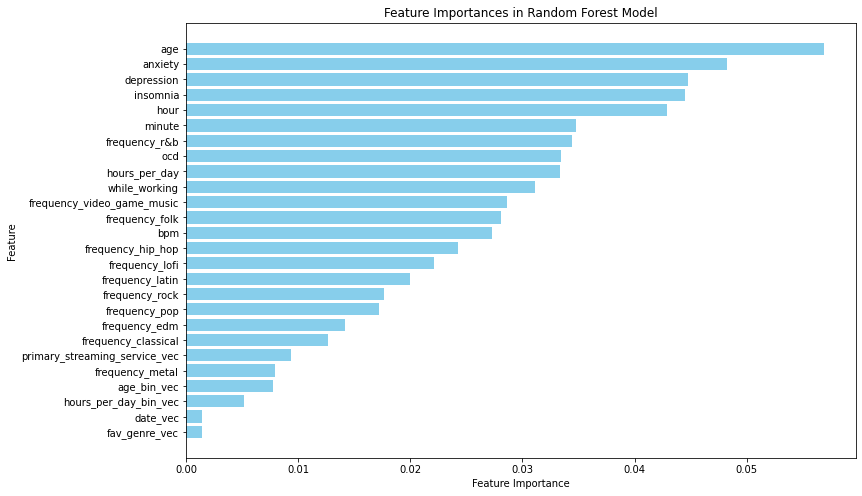

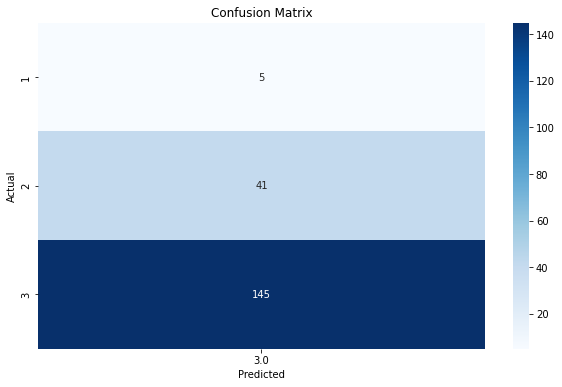

In [39]:
# 7.2

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define string columns and feature columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical", 
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin", 
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b", 
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression", 
                   "insomnia", "ocd", "hour", "minute"]

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# One-hot encode indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")

# Define the RandomForest model with the best-found parameters
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=50, maxDepth=5, minInstancesPerNode=1, featureSubsetStrategy='log2')

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.7, 0.3], seed=42)

# Train the model
rf_model = pipeline.fit(train_df)

# Make predictions
test_predictions = rf_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {accuracy}")

# Additional evaluation metrics
precision_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(test_predictions)
recall = recall_evaluator.evaluate(test_predictions)
f1_score = f1_evaluator.evaluate(test_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

# Extract feature importances
feature_importances = rf_model.stages[-1].featureImportances

# Get feature names
feature_names = assembler.getInputCols()

# Create a DataFrame for feature importances
importance_df = pd.DataFrame(list(zip(feature_names, feature_importances)), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

# Create a confusion matrix
actual = test_df.select("music_effects").toPandas()
predicted = test_predictions.select("prediction").toPandas()
confusion_matrix = pd.crosstab(actual["music_effects"], predicted["prediction"], rownames=["Actual"], colnames=["Predicted"])

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


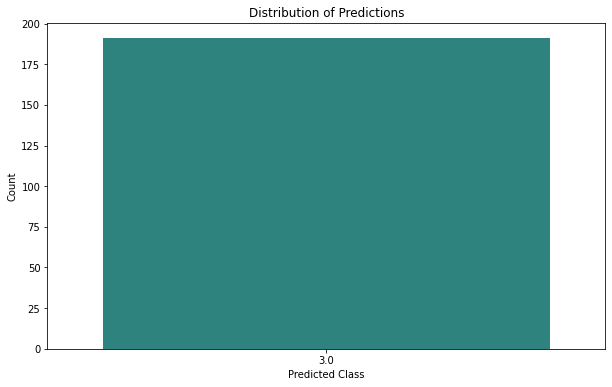

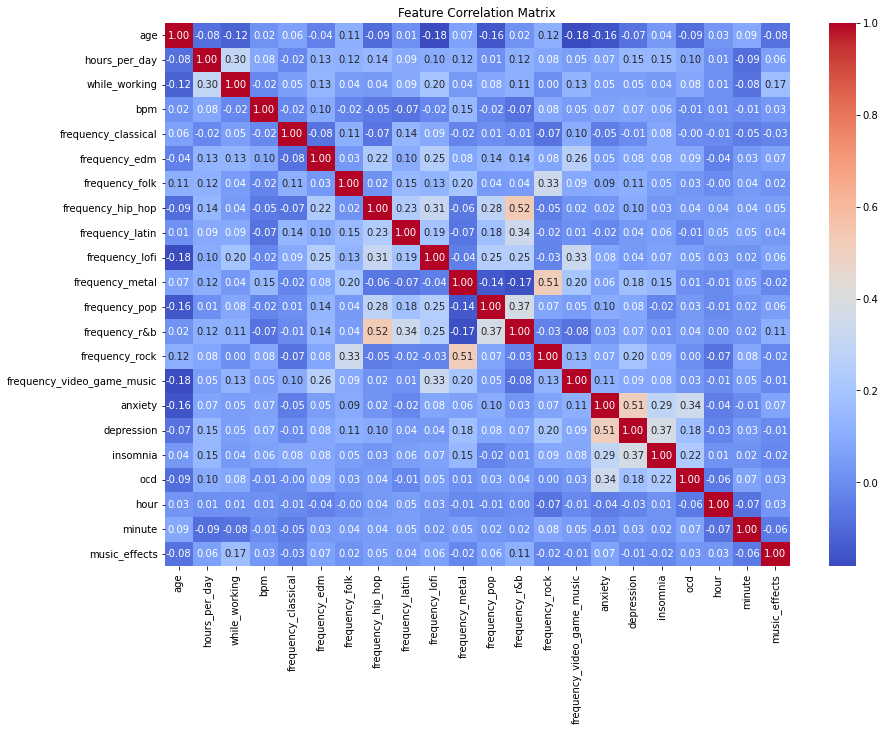

              precision    recall  f1-score   support

     Class 0       0.09      0.20      0.12         5
     Class 1       0.21      0.15      0.17        41
     Class 2       0.78      0.81      0.80       145

    accuracy                           0.65       191
   macro avg       0.36      0.39      0.36       191
weighted avg       0.64      0.65      0.65       191



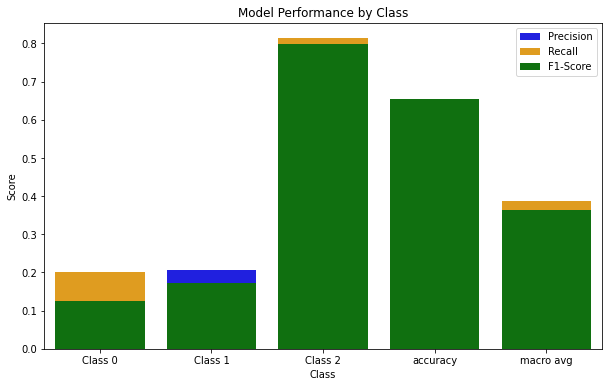

In [50]:
# Distribution of predictions
plt.figure(figsize=(10, 6))
sns.countplot(x="prediction", data=test_predictions.toPandas(), palette="viridis")
plt.title("Distribution of Predictions")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.show()
# Feature correlations
correlation_matrix = combined_transformed_df.toPandas()[feature_columns + ['music_effects']].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(actual, predicted, target_names=["Class 0", "Class 1", "Class 2"])
print(report)

# Visualization
report_df = pd.DataFrame(classification_report(actual, predicted, target_names=["Class 0", "Class 1", "Class 2"], output_dict=True)).transpose()

plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index[:-1], y=report_df['precision'][:-1], color="blue", label="Precision")
sns.barplot(x=report_df.index[:-1], y=report_df['recall'][:-1], color="orange", label="Recall")
sns.barplot(x=report_df.index[:-1], y=report_df['f1-score'][:-1], color="green", label="F1-Score")
plt.legend()
plt.title("Model Performance by Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.show()


0    [0.0, 0.018631189471425207, 0.305245326257118,...
1    [0.0, 0.03960460991430024, 0.15654358087341136...
2    [0.0, 0.018769785678708732, 0.2724674266234920...
3    [0.0, 0.016892617168744756, 0.1793134576305722...
4    [0.0, 0.01934205202744983, 0.16628831980741537...
Name: probability, dtype: object


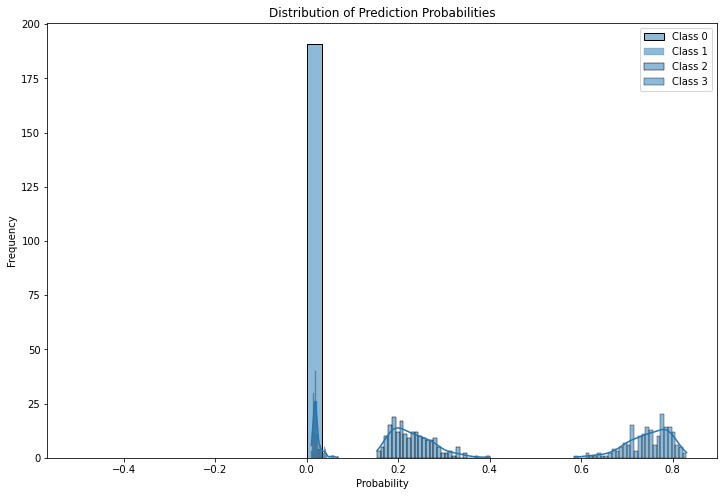

In [52]:
# Inspect the probability column
probabilities = rf_model.stages[-1].transform(test_df).select("probability").toPandas()
print(probabilities['probability'].head())
# Assuming the probability column contains vectors of length 4
probability_length = len(probabilities['probability'][0])
columns = [f"Class {i}" for i in range(probability_length)]

# Create DataFrame
probabilities_df = pd.DataFrame(probabilities['probability'].tolist(), columns=columns)

plt.figure(figsize=(12, 8))
for i, col in enumerate(probabilities_df.columns):
    sns.histplot(probabilities_df[col], kde=True, label=f"Class {i}", bins=30)
plt.title("Distribution of Prediction Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()


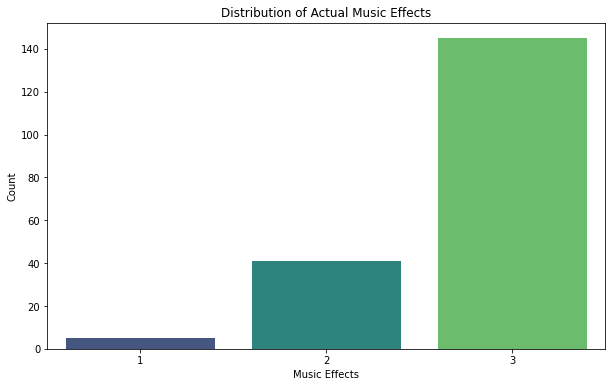

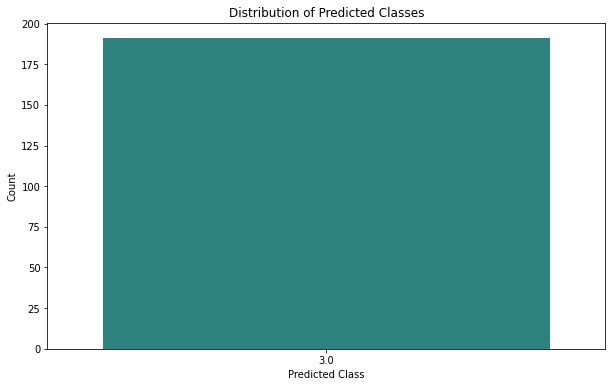

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_predictions contains the predicted labels and actual contains the true labels
actual = test_df.select("music_effects").toPandas()
predicted = test_predictions.select("prediction").toPandas()

# Plot the distribution of actual music_effects values
plt.figure(figsize=(10, 6))
sns.countplot(x=actual["music_effects"], palette="viridis")
plt.title("Distribution of Actual Music Effects")
plt.xlabel("Music Effects")
plt.ylabel("Count")
plt.show()

# Plot the distribution of predicted classes
plt.figure(figsize=(10, 6))
sns.countplot(x=predicted["prediction"], palette="viridis")
plt.title("Distribution of Predicted Classes")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.show()


In [41]:
from pyspark.sql.functions import col, when

# Creating new features
combined_transformed_df = combined_transformed_df.withColumn(
    "hours_per_day_bins",
    when(col("hours_per_day") < 2, "Low").when(col("hours_per_day") < 5, "Medium").otherwise("High")
)

# StringIndexer for the new categorical feature
indexer_new = StringIndexer(inputCol="hours_per_day_bins", outputCol="hours_per_day_bins_indexed", handleInvalid='keep')

# Add the new feature to the list
string_cols.append('hours_per_day_bins')
indexers.append(indexer_new)
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define multiple evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="f1")

# Train the model using cross-validation
cv_model = cv.fit(train_df)

# Evaluate the best model on the test set with multiple metrics
test_predictions = best_model.transform(test_df)
accuracy = accuracy_evaluator.evaluate(test_predictions)
precision = precision_evaluator.evaluate(test_predictions)
recall = recall_evaluator.evaluate(test_predictions)
f1_score = f1_evaluator.evaluate(test_predictions)

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1_score}")


24/05/23 21:28:05 WARN DAGScheduler: Broadcasting large task binary with size 1062.4 KiB
24/05/23 21:28:05 WARN DAGScheduler: Broadcasting large task binary with size 1134.7 KiB
24/05/23 21:28:05 WARN DAGScheduler: Broadcasting large task binary with size 1166.0 KiB
24/05/23 21:28:05 WARN DAGScheduler: Broadcasting large task binary with size 1183.8 KiB
24/05/23 21:28:06 WARN DAGScheduler: Broadcasting large task binary with size 1038.6 KiB
24/05/23 21:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1062.4 KiB
24/05/23 21:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1134.7 KiB
24/05/23 21:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1166.0 KiB
24/05/23 21:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1183.8 KiB
24/05/23 21:28:09 WARN DAGScheduler: Broadcasting large task binary with size 1038.6 KiB
24/05/23 21:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.3 KiB
24/05/23 21:28:10 WAR

24/05/23 21:29:34 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 21:29:35 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/05/23 21:29:35 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 21:29:37 WARN DAGScheduler: Broadcasting large task binary with size 1238.1 KiB
24/05/23 21:29:37 WARN DAGScheduler: Broadcasting large task binary with size 1718.0 KiB
24/05/23 21:29:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 21:29:38 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 21:29:38 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/05/23 21:29:39 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 21:29:40 WARN DAGScheduler: Broadcasting large task binary with size 1190.4 KiB
24/05/23 21:29:40 WARN DAGScheduler: Broadcasting large task binary with size 1642.4 KiB
24/05/23 21:29:41 WARN DAGScheduler: Broad

24/05/23 21:30:21 WARN DAGScheduler: Broadcasting large task binary with size 2006.7 KiB
24/05/23 21:30:21 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 21:30:22 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 21:30:22 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/23 21:30:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 21:30:22 WARN DAGScheduler: Broadcasting large task binary with size 1553.0 KiB
24/05/23 21:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1029.8 KiB
24/05/23 21:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1575.8 KiB
24/05/23 21:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1230.2 KiB
24/05/23 21:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1621.9 KiB
24/05/23 21:30:25 WARN DAGScheduler: Broadcasting large task binary with size 2006.7 KiB
24/05/23 21:30:26 WARN DAGSchedul

24/05/23 21:32:00 WARN DAGScheduler: Broadcasting large task binary with size 2016.8 KiB
24/05/23 21:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1211.7 KiB
24/05/23 21:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1491.3 KiB
24/05/23 21:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1759.0 KiB
24/05/23 21:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1999.7 KiB
24/05/23 21:32:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 21:32:03 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 21:32:03 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 21:32:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 21:32:03 WARN DAGScheduler: Broadcasting large task binary with size 1990.3 KiB
24/05/23 21:32:03 WARN DAGScheduler: Broadcasting large task binary with size 1680.0 KiB
24/05/23 21:32:03 WARN DAGSchedul

24/05/23 21:33:09 WARN DAGScheduler: Broadcasting large task binary with size 1320.8 KiB
24/05/23 21:33:09 WARN DAGScheduler: Broadcasting large task binary with size 1345.2 KiB
24/05/23 21:33:09 WARN DAGScheduler: Broadcasting large task binary with size 1178.2 KiB
24/05/23 21:33:11 WARN DAGScheduler: Broadcasting large task binary with size 1208.7 KiB
24/05/23 21:33:11 WARN DAGScheduler: Broadcasting large task binary with size 1668.5 KiB
24/05/23 21:33:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 21:33:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/05/23 21:33:12 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/05/23 21:33:13 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/23 21:33:13 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/05/23 21:33:14 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/05/23 21:33:14 WARN DAGScheduler: Br

24/05/23 21:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1064.7 KiB
24/05/23 21:33:53 WARN DAGScheduler: Broadcasting large task binary with size 1168.2 KiB
24/05/23 21:33:53 WARN DAGScheduler: Broadcasting large task binary with size 1320.7 KiB
24/05/23 21:33:53 WARN DAGScheduler: Broadcasting large task binary with size 1345.2 KiB
24/05/23 21:33:53 WARN DAGScheduler: Broadcasting large task binary with size 1178.2 KiB
24/05/23 21:34:06 WARN DAGScheduler: Broadcasting large task binary with size 1021.8 KiB
24/05/23 21:34:08 WARN DAGScheduler: Broadcasting large task binary with size 1021.8 KiB
24/05/23 21:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1021.8 KiB
24/05/23 21:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1150.7 KiB
24/05/23 21:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1257.6 KiB
24/05/23 21:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1342.7 KiB
24/05/23 21:34:21 WAR

24/05/23 21:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1205.5 KiB
24/05/23 21:35:27 WARN DAGScheduler: Broadcasting large task binary with size 1134.7 KiB
24/05/23 21:35:27 WARN DAGScheduler: Broadcasting large task binary with size 1224.5 KiB
24/05/23 21:35:27 WARN DAGScheduler: Broadcasting large task binary with size 1261.0 KiB
24/05/23 21:35:27 WARN DAGScheduler: Broadcasting large task binary with size 1140.8 KiB
24/05/23 21:35:35 WARN DAGScheduler: Broadcasting large task binary with size 1094.2 KiB
24/05/23 21:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1094.2 KiB
24/05/23 21:35:39 WARN DAGScheduler: Broadcasting large task binary with size 1042.2 KiB
24/05/23 21:35:50 WARN DAGScheduler: Broadcasting large task binary with size 1298.0 KiB
24/05/23 21:35:51 WARN DAGScheduler: Broadcasting large task binary with size 1796.9 KiB
24/05/23 21:35:51 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 21:35:51 WARN D

24/05/23 21:36:34 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/23 21:36:35 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/05/23 21:36:35 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/05/23 21:36:36 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/05/23 21:36:36 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/05/23 21:36:36 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/05/23 21:36:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/05/23 21:36:37 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 21:36:37 WARN DAGScheduler: Broadcasting large task binary with size 1487.7 KiB
24/05/23 21:36:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/23 21:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1277.5 KiB
24/05/23 21:36:39 WARN DAGScheduler: Broadcastin

24/05/23 21:38:06 WARN DAGScheduler: Broadcasting large task binary with size 1423.7 KiB
24/05/23 21:38:08 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
24/05/23 21:38:08 WARN DAGScheduler: Broadcasting large task binary with size 1306.0 KiB
24/05/23 21:38:08 WARN DAGScheduler: Broadcasting large task binary with size 1423.7 KiB
24/05/23 21:38:10 WARN DAGScheduler: Broadcasting large task binary with size 1032.0 KiB
24/05/23 21:38:10 WARN DAGScheduler: Broadcasting large task binary with size 1187.9 KiB
24/05/23 21:38:11 WARN DAGScheduler: Broadcasting large task binary with size 1305.5 KiB
24/05/23 21:38:19 WARN DAGScheduler: Broadcasting large task binary with size 1237.2 KiB
24/05/23 21:38:19 WARN DAGScheduler: Broadcasting large task binary with size 1526.9 KiB
24/05/23 21:38:19 WARN DAGScheduler: Broadcasting large task binary with size 1810.6 KiB
24/05/23 21:38:19 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/05/23 21:38:20 WARN D

24/05/23 21:39:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 21:39:22 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 21:39:23 WARN DAGScheduler: Broadcasting large task binary with size 1379.9 KiB
24/05/23 21:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1158.1 KiB
24/05/23 21:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1418.8 KiB
24/05/23 21:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1638.7 KiB
24/05/23 21:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1671.9 KiB
24/05/23 21:39:26 WARN DAGScheduler: Broadcasting large task binary with size 1407.1 KiB
24/05/23 21:39:26 WARN DAGScheduler: Broadcasting large task binary with size 1057.6 KiB
24/05/23 21:39:28 WARN DAGScheduler: Broadcasting large task binary with size 1158.1 KiB
24/05/23 21:39:28 WARN DAGScheduler: Broadcasting large task binary with size 1418.8 KiB
24/05/23 21:39:28 WARN DAGS

24/05/23 21:40:05 WARN DAGScheduler: Broadcasting large task binary with size 1440.4 KiB
24/05/23 21:40:06 WARN DAGScheduler: Broadcasting large task binary with size 1501.4 KiB
24/05/23 21:40:07 WARN DAGScheduler: Broadcasting large task binary with size 1158.1 KiB
24/05/23 21:40:07 WARN DAGScheduler: Broadcasting large task binary with size 1418.8 KiB
24/05/23 21:40:08 WARN DAGScheduler: Broadcasting large task binary with size 1638.7 KiB
24/05/23 21:40:08 WARN DAGScheduler: Broadcasting large task binary with size 1671.9 KiB
24/05/23 21:40:08 WARN DAGScheduler: Broadcasting large task binary with size 1407.1 KiB
24/05/23 21:40:09 WARN DAGScheduler: Broadcasting large task binary with size 1065.0 KiB
24/05/23 21:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1158.1 KiB
24/05/23 21:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1418.8 KiB
24/05/23 21:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1638.7 KiB
24/05/23 21:40:11 WAR

24/05/23 21:41:40 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 21:41:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/23 21:41:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 21:41:41 WARN DAGScheduler: Broadcasting large task binary with size 1860.7 KiB
24/05/23 21:41:41 WARN DAGScheduler: Broadcasting large task binary with size 1466.6 KiB
24/05/23 21:41:41 WARN DAGScheduler: Broadcasting large task binary with size 1031.2 KiB
24/05/23 21:41:41 WARN DAGScheduler: Broadcasting large task binary with size 2036.8 KiB
24/05/23 21:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1063.1 KiB
24/05/23 21:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1234.8 KiB
24/05/23 21:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1377.1 KiB
24/05/23 21:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1430.2 KiB
24/05/23 21:41:43 WARN DAGSche

24/05/23 21:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1265.6 KiB
24/05/23 21:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1742.7 KiB
24/05/23 21:42:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 21:42:51 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 21:42:51 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/05/23 21:42:51 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/05/23 21:42:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/05/23 21:42:52 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/05/23 21:42:53 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/05/23 21:42:53 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/05/23 21:42:53 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/05/23 21:42:54 WARN DAGScheduler: Broadcastin

Test Accuracy: 0.7591623036649214
Test Precision: 0.5763274033058304
Test Recall: 0.7591623036649214
Test F1 Score: 0.6552293692346048


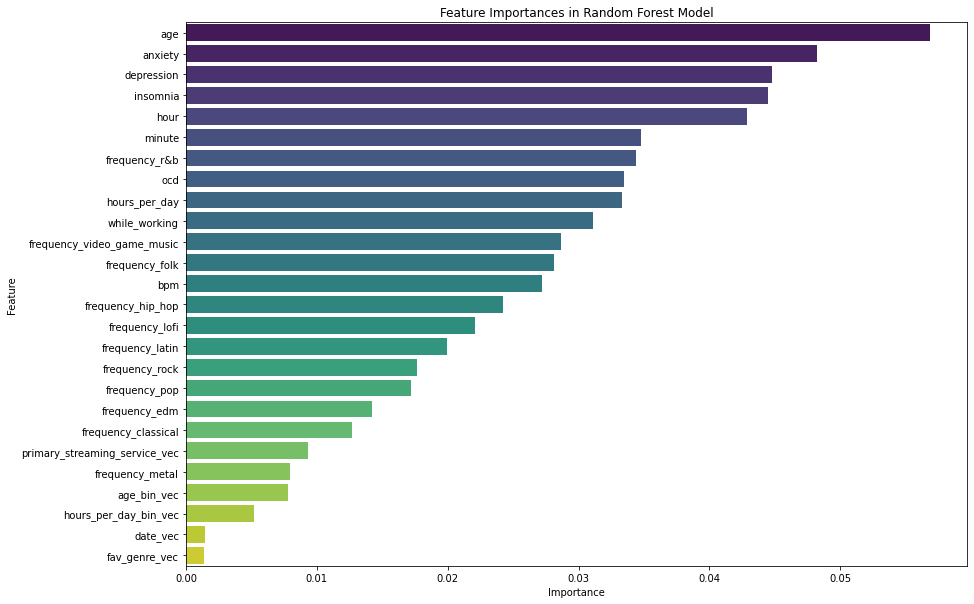

In [42]:
#8.3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances
feature_importances = best_model.stages[-1].featureImportances

# Get feature names
feature_names = assembler.getInputCols()

# Create a DataFrame for feature importances
importance_df = pd.DataFrame(list(zip(feature_names, feature_importances)), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(14, 10))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Feature Importances in Random Forest Model")
plt.show()


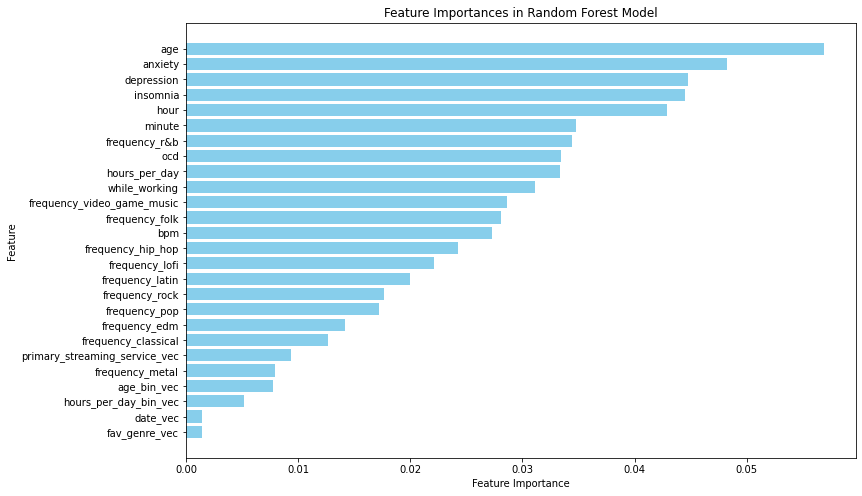

Precision: 0.5763274033058304
Recall: 0.7591623036649214


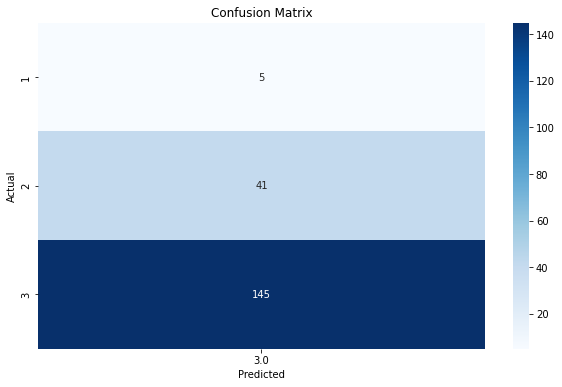

In [38]:
# Extract feature importances
feature_importances = best_model.stages[-1].featureImportances

# Get feature names
feature_names = assembler.getInputCols()

# Create a DataFrame for feature importances
importance_df = pd.DataFrame(list(zip(feature_names, feature_importances)), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

# Display precision and recall
precision_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedRecall")

precision = precision_evaluator.evaluate(test_predictions)
recall = recall_evaluator.evaluate(test_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Create a confusion matrix
actual = test_df.select("music_effects").toPandas()
predicted = test_predictions.select("prediction").toPandas()
confusion_matrix = pd.crosstab(actual["music_effects"], predicted["prediction"], rownames=["Actual"], colnames=["Predicted"])

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### 8

24/05/23 22:10:23 WARN Instrumentation: [69bcc4bc] All labels are the same value and fitIntercept=true, so the coefficients will be zeros. Training is not needed.


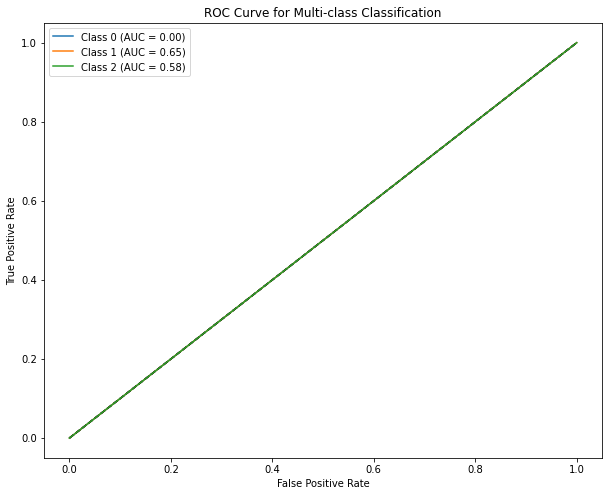

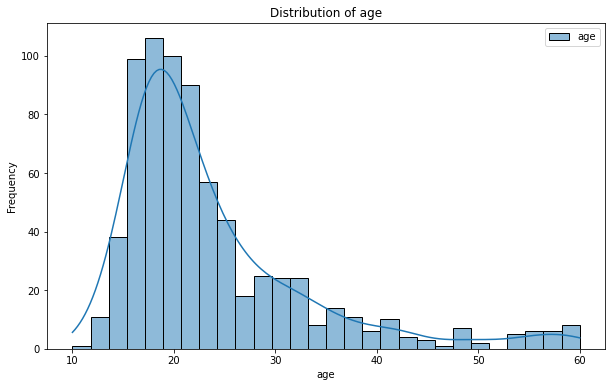

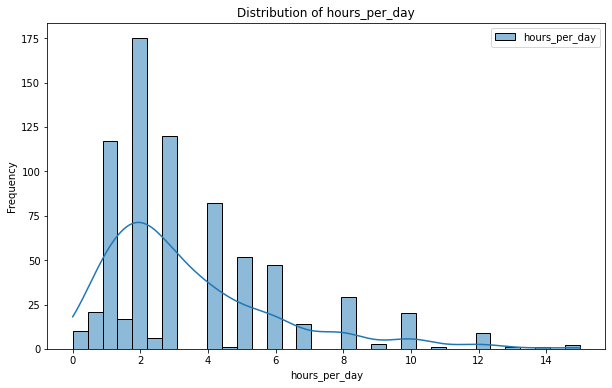

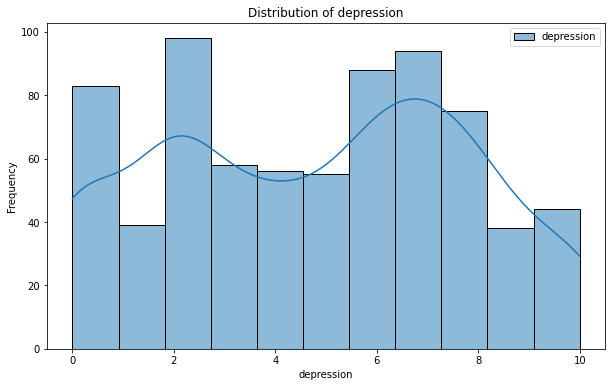

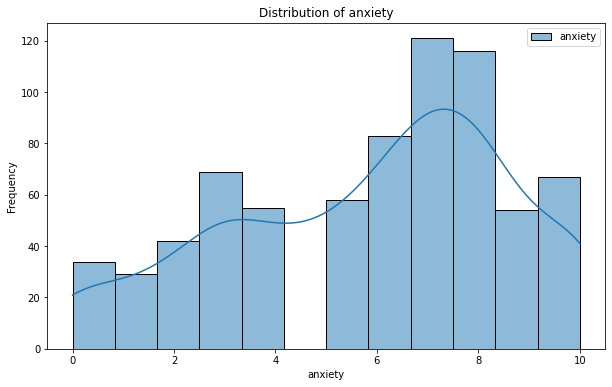

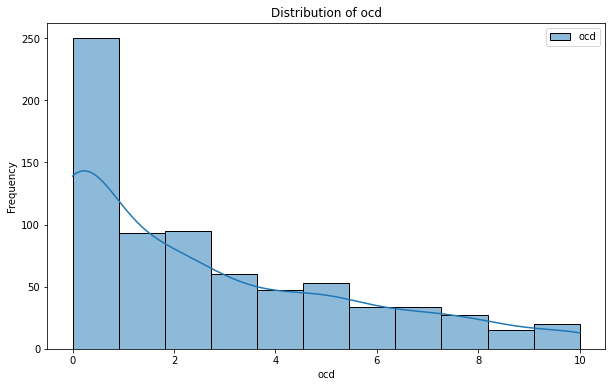

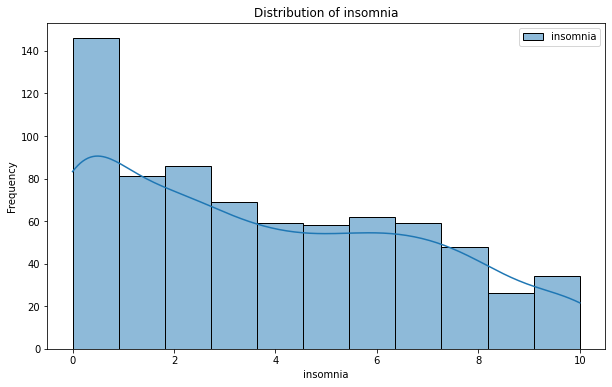

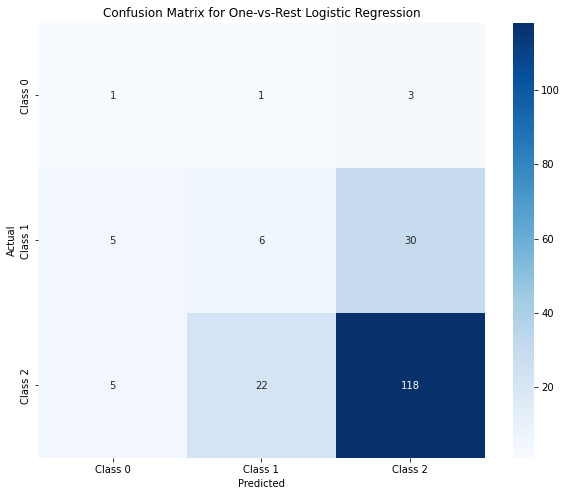

In [49]:
from pyspark.ml.classification import OneVsRest, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Define string columns and feature columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical", 
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin", 
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b", 
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression", 
                   "insomnia", "ocd", "hour", "minute"]

# Creating new features
combined_transformed_df = combined_transformed_df.withColumn(
    "hours_per_day_bins",
    F.when(F.col("hours_per_day") < 2, "Low").when(F.col("hours_per_day") < 5, "Medium").otherwise("High")
)

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]
indexer_new = StringIndexer(inputCol="hours_per_day_bins", outputCol="hours_per_day_bins_indexed", handleInvalid='keep')
indexers.append(indexer_new)

# One-hot encode indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols + ['hours_per_day_bins']]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols + ['hours_per_day_bins']], outputCol="features")

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Transform the data to include the 'features' column
transformed_df = pipeline.fit(combined_transformed_df).transform(combined_transformed_df)

# Train-test split
train_df, test_df = transformed_df.randomSplit([0.7, 0.3], seed=42)

# Define the base classifier for OvR
lr = LogisticRegression(featuresCol="features", labelCol="music_effects")

# Define the One-vs-Rest classifier
ovr = OneVsRest(classifier=lr, labelCol="music_effects")

# Train the One-vs-Rest model
ovr_model = ovr.fit(train_df)

# Make predictions
ovr_predictions = ovr_model.transform(test_df)

# Evaluate the model using BinaryClassificationEvaluator
roc_evaluators = []
for i in range(3):  # Assuming 3 classes
    evaluator = BinaryClassificationEvaluator(labelCol="binary_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    test_predictions_class = ovr_predictions.withColumn("binary_label", F.when(F.col("music_effects") == i, 1).otherwise(0))
    auc = evaluator.evaluate(test_predictions_class)
    roc_evaluators.append((i, auc))

# Plot ROC curves
plt.figure(figsize=(10, 8))
for label, auc in roc_evaluators:
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0, auc, 1], [0, auc, 1], label=f'Class {label} (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='best')
plt.show()

# Plotting distribution of a few key features
key_features = ["age", "hours_per_day", "depression", "anxiety", "ocd", "insomnia"]

for feature in key_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=combined_transformed_df.select(feature).toPandas(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Additional visualization: Confusion matrix heatmap
from sklearn.metrics import confusion_matrix

# Convert predictions to Pandas DataFrame
actual = test_df.select("music_effects").toPandas()
predicted = ovr_predictions.select("prediction").toPandas()

# Create a confusion matrix
conf_matrix = confusion_matrix(actual, predicted)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for One-vs-Rest Logistic Regression')
plt.show()



In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# List of feature columns
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical", 
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin", 
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b", 
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression", 
                   "insomnia", "ocd", "hour", "minute"]

# String columns to be indexed and one-hot encoded
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# One-hot encode indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")

# Define the DecisionTree model
dt = DecisionTreeClassifier(labelCol="music_effects", featuresCol="features")

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, dt])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)

# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 10, 20])
             .addGrid(dt.minInstancesPerNode, [1, 5, 10])
             .build())

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="accuracy")

# Define the cross-validator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Train the model using cross-validation
cv_model = cv.fit(train_df)

# Get the best model
best_model = cv_model.bestModel

# Print the best parameters
print(f"Best maxDepth: {best_model.stages[-1].getMaxDepth()}")
print(f"Best minInstancesPerNode: {best_model.stages[-1].getMinInstancesPerNode()}")

# Evaluate the best model on the test set
test_predictions = best_model.transform(test_df)
accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {accuracy}")

# Evaluate precision and recall
evaluator_precision = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedRecall")

precision = evaluator_precision.evaluate(test_predictions)
recall = evaluator_recall.evaluate(test_predictions)

print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
